In [95]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/amharic-hate-speech-detection-dataset/Data/READEME.md
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/dev.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/with_annotators_dev.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/with_annotators_train.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/with_annotators_test.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/README.md
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/train.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/RANLP2023/test.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/ICT4DA/README.md
/kaggle/input/amharic-hate-speech-detection-dataset/Data/ICT4DA/train.csv
/kaggle/input/amharic-hate-speech-detection-dataset/Data/ICT4DA/test.csv
/kaggle/input/hate-speech/Posts.txt
/kaggle/input/hate-speech/Labels.txt


In [98]:
import re
import unicodedata
def clean_text(text):
    text = unicodedata.normalize('NFKC', text)
    text = text.lower()  
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text)  

    return text

In [99]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import plotly.express as px
import nltk 
from tensorflow.keras import regularizers
import keras
from keras.activations import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Read the dataset
posts = pd.read_csv('/kaggle/input/hate-speech/Posts.txt', header=None, names=['sentence'])
labels = pd.read_csv('/kaggle/input/hate-speech/Labels.txt', header=None, names=['label'])

posts.columns = ['post']
labels.columns = ['labels']

labels['labels'] = labels['labels'].str.strip()

posts['Num_words'] = posts['post'].apply(lambda x:len(str(x).split()))
posts['post'] = posts['post'].apply(clean_text)
posts = pd.concat([posts, labels], axis=1)


In [100]:
single_words = posts['Num_words'] < 2
small_sentences = posts[single_words]
small_sentences.head()

,post,Num_words,labels
140,ዘርእየጠራንከምንወቃቀስሁሉምየጌታፍጥረቶችናቸውአሁንበቃንእንፀልይ,1,Free
334,ሰማእታት,1,Free
412,እግዚአብሄርሆይምረቱንላክልን,1,Free
806,ጋላየውገኑንብልእትቆርጦእናየብልእትቋንጣይዞየሜዞእርእሳርያልበላከብትእራሱጋ...,1,Free
833,እኔየሚገርመኝአሁንእድህየሚሆኑትምንለመሆንነዉ,1,Hate


In [101]:
leng = []
one_word = []
for word in small_sentences['post']:
    leng.append(len(word))
    if len(word) < 10:
        one_word.append(word)

print(len(one_word))
longest = np.array(leng).max()

425


In [102]:
sentences = posts['Num_words'] > 1
dataset = posts[sentences]
print(dataset.shape)
dataset.head()

(29463, 3)


,post,Num_words,labels
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,63,Free
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...,10,Free
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...,19,Free
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...,23,Free
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...,25,Hate


In [103]:
plot_df = dataset.Num_words.value_counts().rename_axis('Num_words').reset_index(name='counts')

fig = px.bar(plot_df, x="Num_words", y="counts", color="counts", title="Sentence Length Distribution")
fig.show()

In [104]:
many_words = dataset['Num_words'] > 55
large_sentences = dataset[many_words]
large_sentences

,post,Num_words,labels
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,63,Free
282,ነፍስ ይማርልን ለወገኖቻችን እነዚህ ነፍሰበላ ደንቆሮ አህያነጅሁሉ ዋጋቸው...,94,Hate
467,ወንድሜ ታደለ ይሄን ጦማር ስትጦምር እያለቀስክ ሊሆን እንሚችል እገምታለሁ...,57,Free
576,ሞታቸው እጅግ ያማል ነገር ግን ለተፈጠረው ችግር ተጠያቂው መንግስት እንጅ...,63,Free
752,በተኮል ምናብ ቆመ ድንጋይ ይልቅ እናንተ የፈፀማቹት ግፍ እጅጉን ይልቃል ...,71,Hate
...,...,...,...
29113,የብሄራዊ እርቅና መግባባት ኮሚሽን ስራዉ ዉጤታማ መሆን ካለበት የዎቹ ትዉ...,66,Free
29655,ፖለቲካ አንዳች ነገር የማናዉቅ ነገር ግን ከእኛ በላይ ፖለቲካ ላሳር ነ...,110,Free
29666,በተለይ በተግደርዳሪ የፖለቲካ ሀይሎች ዘንድ ያለዉ ዝግጁነት እና የፖለቲካ...,63,Free
29743,ሚኪ በጣም ጥሩ ሀሳብ ነው ማንም ለ አማራ ህዝብ አስባለሁ የሚል አክቲቪስ...,58,Free


In [105]:
max_length = 55
num_words = dataset['Num_words'] <= max_length
dataset = dataset[num_words]
dataset.shape

(28608, 3)

In [106]:
plot_df = dataset.Num_words.value_counts().rename_axis('Num_words').reset_index(name='counts')

fig = px.bar(plot_df, x="Num_words", y="counts", color="counts", title="Sentence Length Distribution")
fig.show()

<Axes: ylabel='count'>

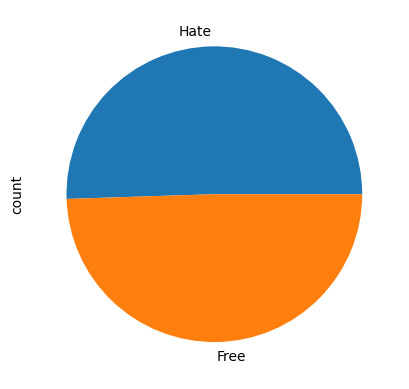

In [107]:
post = dataset['post'].values
label = dataset['labels'].values
dataset['labels'].value_counts().plot(kind = 'pie')

In [1]:
mask = (posts['Num_words'] > 2) & (posts['Num_words'] < 85)

filtered_posts = posts[mask]
filtered_labels = labels[mask]
print(filtered_posts)


NameError: name 'posts' is not defined

In [109]:
X_train, X_test, y_train, y_test = train_test_split(dataset['post'], dataset['labels'], test_size=0.1, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=5000) 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

svm_model = SVC(kernel='linear')  
svm_model.fit(X_train_tfidf, y_train_encoded)

predictions = svm_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test_encoded, predictions))
print("\nClassification Report:\n", classification_report(y_test_encoded, predictions, target_names=le.classes_))

Accuracy: 0.6329954561342188

Classification Report:
               precision    recall  f1-score   support

        Free       0.63      0.60      0.61      1388
        Hate       0.64      0.66      0.65      1473

    accuracy                           0.63      2861
   macro avg       0.63      0.63      0.63      2861
weighted avg       0.63      0.63      0.63      2861



In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
X_train, X_test, y_train, y_test = train_test_split(filtered_posts['post'], filtered_labels['labels'], test_size=0.1, random_state=42)

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100  
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_padded, y_train_encoded, batch_size=64, epochs=5, validation_split=0.1, verbose=1)

predictions = model.predict(X_test_padded).round().astype(int)
print("Accuracy:", accuracy_score(y_test_encoded, predictions))
print("\nClassification Report:\n", classification_report(y_test_encoded, predictions, target_names=encoder.classes_))


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(max_features=1000)  
X = vectorizer.fit_transform(posts['post'])
y = labels['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))  
X = vectorizer.fit_transform(filtered_posts['post'])
y = filtered_labels['labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Model Accuracy:", accuracy_rf)

svm_model = SVC(kernel='linear', C=1)  
svm_scores = cross_val_score(svm_model, X, y, cv=5)  
print("SVM Model Cross-Validation Mean Accuracy:", svm_scores.mean())